In [1]:
from dataset import get_mnist_dataset
train_set, train_classes = get_mnist_dataset(train=True)
val_set, val_classes = get_mnist_dataset(train=False, total_data=1000)

/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify al

In [3]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistAEDGCCA
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [True],
    latent_dim = [10]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistAEDGCCA(output_size=run.latent_dim)
    dgcca = dgcca.to('cpu')
        
    train_views = list(train_set.to('cpu'))
    val_views = list(val_set.to('cpu'))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0

        dgcca.to('cuda')
        for i in trange(num_batches):
            
            optimizer.zero_grad()
            batch = []
            
            # mini batch gradient
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
            target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')
            
            latent = dgcca(batch)
            
            ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))
            
            dgcca_loss = 1/2*torch.norm(latent[0]-latent[1]) 

            loss = dgcca_loss + ae_loss
            
            loss.backward()
            
            optimizer.step()
            
            total_recons_loss += loss.item()
            del batch, target, latent
        
        dgcca.to('cpu')
#         out = torch.stack(dgcca(train_views)).detach().clone()        
#         if run.quant:
#             for i in range(I):
#                 diff = out[i] - M_serv[i]
#                 max_val = diff.abs().max()
#                 quant = ((1/max_val)*diff[i]).round()*(max_val/1)
#                 var = M_serv[i] + quant
#                 M_serv[i] = var
#                 del max_val, diff, quant, var
#             G = g_step(M_serv.clone().detach())
#         else:
#             G = g_step(out.clone().detach())   
            
        # validation loss
#         t1 = time.time()
#         out_val = dgcca(val_views)
#         out_val = torch.stack(out_val)
        
#         G_val = g_step(out_val.clone().detach())
        
#         loss_val = criterion(out_val, G_val)
#         total_val_loss += loss_val.item()
#         t = time.time() - t1
#         print("optim step", time.time() - t1); t1 = time.time()
    
#         del G_val, out_val

        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches/10
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dcca_test.model')
    

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,1.060432,0,1000,0.001,cpu
1,1,1,0.298852,0,1000,0.001,cpu
2,1,2,0.247104,0,1000,0.001,cpu
3,1,3,0.239171,0,1000,0.001,cpu
4,1,4,0.249876,0,1000,0.001,cpu
...,...,...,...,...,...,...,...
95,1,95,0.070455,0,1000,0.001,cpu
96,1,96,0.069500,0,1000,0.001,cpu
97,1,97,0.066231,0,1000,0.001,cpu
98,1,98,0.070964,0,1000,0.001,cpu


Text(0.5, 1.0, 't-SNE plot of latent representation G')

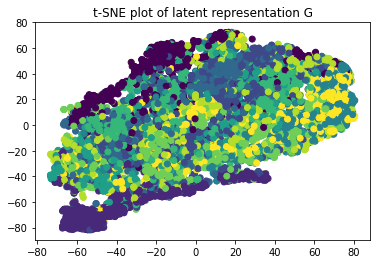

In [4]:
dgcca.eval()
out = torch.stack(dgcca(train_views))

import numpy as np
from sklearn.manifold import TSNE

a = out[0][:10000].clone().detach()
X = a.numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1)

axes.scatter(X_embedded[:10000,0], X_embedded[:10000,1], c=train_classes[:10000].numpy())
axes.set_title('t-SNE plot of latent representation G')